In [551]:
from keras import backend as K
from keras import regularizers
import scipy.io as sio
import sys
import os
from netCDF4 import Dataset
from keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from keras.layers import Input
from keras.layers import Dense, BatchNormalization, Dropout,GlobalAveragePooling2D
from keras import layers
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import applications
import keras

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from glob import glob
from os.path import join, expanduser

from keras.models import Model, save_model, load_model
from keras.layers import Dense, Activation, Conv2D,Conv2DTranspose, Input, AveragePooling2D, MaxPooling2D, Flatten, LeakyReLU, Dropout,concatenate
from keras.layers import SpatialDropout2D
from keras.optimizers import SGD, Adam
from keras.regularizers import l2

from sklearn.metrics import mean_squared_error, roc_auc_score,r2_score
from sklearn.utils import shuffle
import importlib

import utils
import glob, os
import copy

In [848]:
importlib.reload(utils)

<module 'utils' from '/glade/work/wchapman/Italian_Rain/utils.py'>

In [780]:
#find all files in directory                                                                                                                                                  
print('Training on')
path = os.getcwd()
train_file_names = [f for f in glob.glob(path + "/train/input*.nc", recursive=True)]
for f in train_file_names:
    print(f)
    
print('validating on')
path = os.getcwd()
val_file_names = [f for f in glob.glob(path + "/validation/input*.nc", recursive=True)]
for f in train_file_names:
    print(f)

print('Testing on')
test_file_names = [f for f in glob.glob(path + "/test/input*.nc", recursive=True)]
for f in test_file_names:
    print(f)

Training on
/glade/work/wchapman/Italian_Rain/train/input_rain_train.nc
validating on
/glade/work/wchapman/Italian_Rain/train/input_rain_train.nc
Testing on
/glade/work/wchapman/Italian_Rain/test/input_rain_testing.nc


In [781]:
allit = utils.read_image_file('input_rain_permute.nc')
print(allit['predictor_names'])
print(allit['target_name'])
print(allit['predictor_matrix'].shape)
print(allit['target_matrix'].shape)

['rr', 't2m', 'u10', 'v10', 'u700', 'v700', 'rh700', 'T700', 'W700']
rr_obs
(1770, 3, 169, 9)
(1770, 507)


In [783]:
norm_dict = utils.get_image_normalization_params(train_file_names)

Reading data from: "/glade/work/wchapman/Italian_Rain/train/input_rain_train.nc"...


Mean and standard deviation for "rr" = 4.3848, 14.7119
Mean and standard deviation for "t2m" = 277.0811, 31.0830
Mean and standard deviation for "u10" = 0.3253, 1.0729
Mean and standard deviation for "v10" = -0.2954, 1.2457
Mean and standard deviation for "u700" = 3.3131, 6.2032
Mean and standard deviation for "v700" = -0.1912, 6.9285
Mean and standard deviation for "rh700" = 54.3749, 23.0899
Mean and standard deviation for "T700" = 267.4512, 29.9685
Mean and standard deviation for "W700" = 0.0082, 0.1779


In [787]:
norm_dict_targ = utils.get_image_normalization_params_targ(train_file_names)

Reading data from: "/glade/work/wchapman/Italian_Rain/train/input_rain_train.nc"...


Mean and standard deviation for "rr_obs" = 4.2705, 10.9934


In [788]:
num_samps = utils.count_samps(['input_rain_permute.nc'])
print(num_samps)

Reading data from: "input_rain_permute.nc"...
1770


## Sanity Check - Normalization library: 

predictor_names: ['rr', 't2m', 'u10', 'v10', 'u700', 'v700', 'rh700', 'T700', 'W700']
target_names: rr_obs
21.3492431640625
20.607421875
#############################
(1770, 507)
(1770, 3, 169, 9)
original target field
mininmum original targ: 0.0


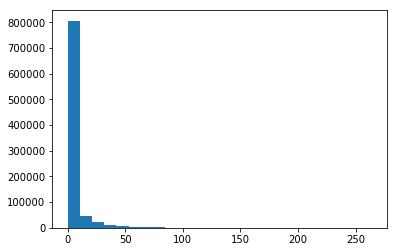

#############################
norm pred:


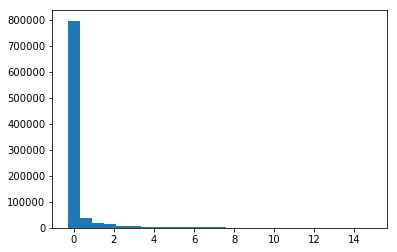

#############################
norm targ:
mininmum_targ: -0.38845762718139776


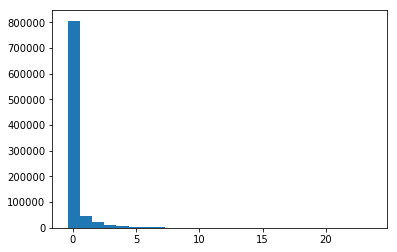

#############################
denorm pred:


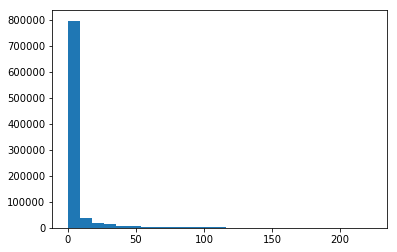

#############################
denorm targ:


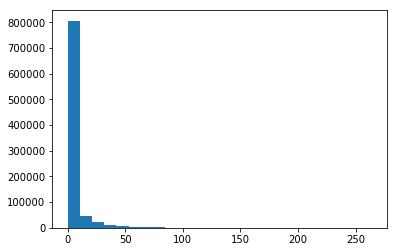

#############################


In [865]:
jago = utils.read_image_file('input_rain_permute.nc')
print('predictor_names:',jago['predictor_names'])
print('target_names:', jago['target_name'])
print(jago['predictor_matrix'][0,0,0,0])
print(jago['target_matrix'][0,0])
print('#############################')
print(jago['target_matrix'].shape)
print(jago['predictor_matrix'].shape)

#standard: 
print('original target field')
print('mininmum original targ:',np.min(jago['target_matrix']))
plt.hist(np.ndarray.flatten(jago['target_matrix']),25)
plt.show()
print('#############################')
pred_mat = utils.normalize_images(jago['predictor_matrix'],jago['predictor_names'],norm_dict)
print('norm pred:')
plt.hist(np.ndarray.flatten(pred_mat[0][:,:,:,0]),25)
plt.show()
print('#############################')
targ_mat = utils.normalize_images_targ(jago['target_matrix'],jago['target_name'],norm_dict_targ)
print('norm targ:')
print('mininmum_targ:',np.min(targ_mat[0][:]))
plt.hist(np.ndarray.flatten(targ_mat[0][:]),25)
plt.show()
print('#############################')
pred_mat = utils.denormalize_images(pred_mat[0], jago['predictor_names'], norm_dict)
print('denorm pred:')
plt.hist(np.ndarray.flatten(pred_mat[:,:,:,0]),25)
plt.show()
print('#############################')
targ_mat = utils.denormalize_images_targ(targ_mat[0],jago['target_name'],norm_dict_targ)
print('denorm targ:')
plt.hist(np.ndarray.flatten(targ_mat[:]),25)
plt.show()
print('#############################')

In [868]:
img_height = pred_mat.shape[1]
img_width = pred_mat.shape[2]
num_channels = pred_mat.shape[3]
out_shape = np.squeeze(np.reshape(targ_mat[0],(1,-1)).shape[1])
learning_rate = 0.001

num_conv_filters = 6
filter_width = 5
conv_activation = "relu"
learning_rate = 0.001


# Input data in shape (instance, y, x, variable)                                                                                                                                                                   
conv_net_in = Input(shape=(img_height,img_width,num_channels))

# First 2D convolution Layer                                                                                                                                                                                       
conv_net = Conv2D(num_conv_filters, (filter_width, filter_width), padding="same")(conv_net_in)
conv_net = keras.layers.LeakyReLU(alpha=0.2)(conv_net)
conv_net = Dropout(0.2)(conv_net)
# Average pooling takes the mean in a 2x2 neighborhood to reduce the image size                                                                                                                                    
conv_net = MaxPooling2D()(conv_net)
conv_net = BatchNormalization()(conv_net)

# Second set of convolution and pooling layers                                                                                                                                                                     
conv_net = Conv2D(num_conv_filters * 2, (filter_width, filter_width), padding="same")(conv_net)
conv_net = keras.layers.LeakyReLU(alpha=0.2)(conv_net)
conv_net = BatchNormalization()(conv_net)
conv_net = Dropout(0.4)(conv_net)

# # Flatten the last convolutional layer into a long feature vector                                                                                                                                                
conv_net = Flatten()(conv_net)                                                                                                                                                                                   
# Dense output layer, equivalent to a logistic regression on the last layer                                                                                                                                        
conv_net = Dense(100)(conv_net)
conv_net = keras.layers.LeakyReLU(alpha=0.2)(conv_net)
conv_net = BatchNormalization()(conv_net)

conv_net = Dense(int(out_shape))(conv_net)
conv_net = Activation("relu")(conv_net)



conv_model = Model(conv_net_in, conv_net)
# Use the Adam optimizer with default parameters                                                                                                                                                                   
opt = Adam(lr=learning_rate)
conv_model.compile(opt, "mse")

conv_model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        (None, 3, 169, 9)         0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 3, 169, 6)         1356      
_________________________________________________________________
leaky_re_lu_122 (LeakyReLU)  (None, 3, 169, 6)         0         
_________________________________________________________________
dropout_75 (Dropout)         (None, 3, 169, 6)         0         
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 1, 84, 6)          0         
_________________________________________________________________
batch_normalization_131 (Bat (None, 1, 84, 6)          24        
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 1, 84, 12)         1812      
__________

In [869]:
norm_dict_targ

{'rr_obs': array([ 4.27045953, 10.99337285])}

In [870]:
batch_num =30
epochs = 100
num_batches_per_ep = int(np.floor(num_samps/batch_num))
num_val_batch_per_ep =1

output_model_file_name ='/glade/work/wchapman/Italian_Rain/models/TEST_GPU_mse_3.h5'

#try to train: 
aa = training_dictionary = utils.train_cnn(conv_model, train_file_names,
norm_dict,norm_dict_targ,batch_num, epochs,
num_batches_per_ep, output_model_file_name,val_file_names,num_val_batch_per_ep)

Normalization dict targ: {'rr_obs': array([ 4.27045953, 10.99337285])}
Epoch 1/100
Reading data from: "/glade/work/wchapman/Italian_Rain/train/input_rain_train.nc"...
58/59 [============================>.] - ETA: 0s - loss: 0.8228Reading data from: "/glade/work/wchapman/Italian_Rain/train/input_rain_train.nc"...
Reading data from: "/glade/work/wchapman/Italian_Rain/validation/input_rain_validate.nc"...
59/59 [==============================] - 22s 371ms/step - loss: 0.8164 - val_loss: 0.4124

Epoch 00001: val_loss improved from inf to 0.41241, saving model to /glade/work/wchapman/Italian_Rain/models/TEST_GPU_mse_3.h5
Epoch 2/100
Reading data from: "/glade/work/wchapman/Italian_Rain/train/input_rain_train.nc"...
58/59 [============================>.] - ETA: 0s - loss: 0.6954Reading data from: "/glade/work/wchapman/Italian_Rain/train/input_rain_train.nc"...
Reading data from: "/glade/work/wchapman/Italian_Rain/validation/input_rain_validate.nc"...
59/59 [==============================] - 

In [871]:
jago = utils.read_image_file('/glade/work/wchapman/Italian_Rain/test/input_rain_testing.nc')
pred_mat = utils.normalize_images(jago['predictor_matrix'],jago['predictor_names'],norm_dict)
truth_mat = jago['target_matrix']

In [872]:
# conv_model = utils.read_keras_model('/glade/work/wchapman/Italian_Rain/models/TEST_GPU.h5')

In [873]:
# heyhey = utils.apply_cnn(conv_model,pred_mat[0])

In [964]:
yo = conv_model.predict(pred_mat[0])

In [965]:
np.max(yo*10.99)

110.66473

In [969]:
rain_guess1 = utils.denormalize_images_targ(yo,jago['target_name'],norm_dict_targ)
targ_mat.shape

(1770, 507)

In [970]:
rain_guess1 = np.reshape(rain_guess1,(59,3,169)) 
rain_guess1[rain_guess1==4.2704597] = 0 
truth_mat = np.reshape(truth_mat,(59,3,169)) 

In [972]:
print(np.max(truth_mat))
print(np.min(rain_guess1))
print(np.mean(forecasts[:,2,:]))
print(np.mean(truth_mat[:,2,:]))
print(np.mean(rain_guess1[:,2,:]))

print(np.sqrt(np.mean((forecasts[:,:,:]-truth_mat[:,:,:])**2)))
print(np.sqrt(np.mean(((rain_guess1[:,:,:])-truth_mat[:,:,:])**2)))

207.98855590820312
0.0
6.6204589897949875
5.0100297501033
3.11141
14.534992224374111
8.447012375232475


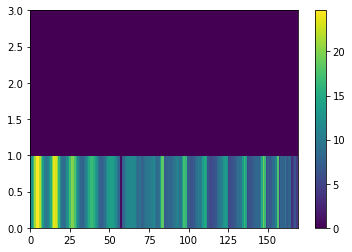

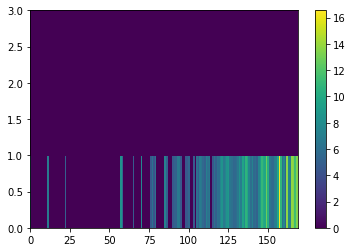

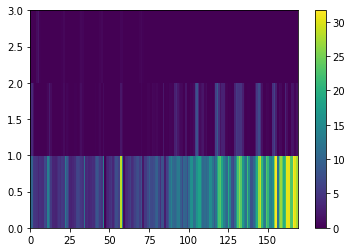

In [973]:
numdo = 40
plt.pcolor(forecasts[numdo,:,:])
plt.colorbar()
plt.show()

plt.pcolor(rain_guess1[numdo,:,:])
plt.colorbar()
plt.show()

plt.pcolor(truth_mat[numdo,:,:])
plt.colorbar()
plt.show()

In [974]:
fcast =  utils.read_image_file('/glade/work/wchapman/Italian_Rain/test/input_rain_testing.nc')
forecasts = fcast['predictor_matrix'][:,:,:,0]

correlation: 0.7240933831559121


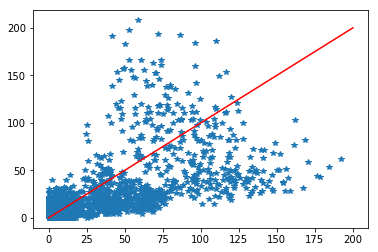

In [975]:
fc = np.ndarray.flatten(forecasts[:,0,:])
trm = np.ndarray.flatten(truth_mat[:,0,:])
print('correlation:',np.corrcoef(fc,trm)[0,1])
plt.plot(fc,trm,'*')
plt.plot([0,200],[0,200],'r')
plt.show()

correlation: 0.8917324633267179


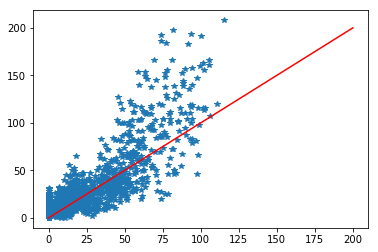

In [978]:
frg = np.ndarray.flatten(rain_guess1[:,0,:])
trm = np.ndarray.flatten(truth_mat[:,0,:])
print('correlation:',np.corrcoef(frg,trm)[0,1])
plt.plot(frg,trm,'*')
plt.plot([0,200],[0,200],'r')
plt.show()

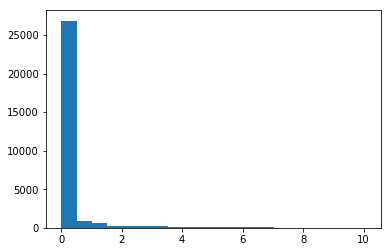

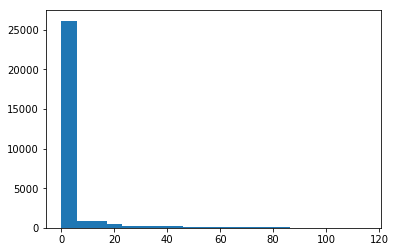

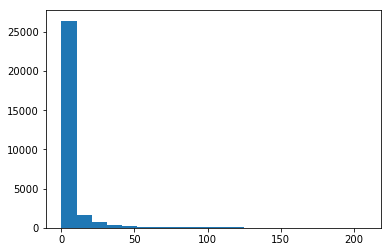

In [979]:
plt.hist(np.ndarray.flatten(yo),20)
plt.show()

plt.hist(np.ndarray.flatten(rain_guess1),20)
plt.show()

plt.hist(np.ndarray.flatten(truth_mat),20)
plt.show()

In [980]:
jago = utils.read_image_file('/glade/work/wchapman/Italian_Rain/test/input_rain_testing.nc')
jago['target_matrix']

array([[2.70020008e-01, 5.90820014e-02, 0.00000000e+00, ...,
        1.08178711e+01, 2.82324195e+00, 9.90917969e+00],
       [2.70020008e-01, 5.90820014e-02, 0.00000000e+00, ...,
        3.89400013e-02, 6.29879981e-02, 7.60499984e-02],
       [5.04882991e-01, 7.42190033e-02, 2.55858988e-01, ...,
        9.99000040e-04, 1.99900009e-03, 1.99900009e-03],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        4.10000011e-02, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.99000040e-04, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [981]:
root_grp = Dataset('Italy_PostProcessed_netcdf4.nc', 'w', format='NETCDF4')
root_grp.description = 'Post-Processed Precip Forecast'


# dimensions
root_grp.createDimension('Days', None)
root_grp.createDimension('Lead times', 3)
root_grp.createDimension('Staz', 169)

# variables
time = root_grp.createVariable('Days', np.float32, ('Days',))
x = root_grp.createVariable('Lead times', np.float32, ('Lead times',))
y = root_grp.createVariable('Staz', 'f4', ('Staz',))
CNN_rr = root_grp.createVariable('CNN_rr', np.float32 , ('Days', 'Lead times', 'Staz',))
rr = root_grp.createVariable('rr', 'f8', ('Days', 'Lead times', 'Staz',))
rr_obs = root_grp.createVariable('rr_obs', 'f8', ('Days', 'Lead times', 'Staz',))

CNN_rr[:] = rain_guess1
rr[:] = fcast['predictor_matrix'][:,:,:,0]
rr_obs[:] = truth_mat
root_grp.close()

In [953]:
hh = Dataset('Italy_PostProcessed_netcdf4.nc')

In [954]:
rrr = hh['rr'][:]
rr_obser = hh['rr_obs'][:]
mygues = hh['CNN_rr'][:]